# ETL Workflow for Forest Cover Change Analysis in the Congo Basin.

In [1]:
import os
import shutil
from datetime import datetime
import rasterio
import pystac
from pystac_client import Client
import geopandas as gpd
from shapely.geometry import box, Polygon, shape
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt 
import zarr
import dask
from dask.distributed import Client
import dask.array as da
from dask.diagnostics import ProgressBar

In [2]:
# Better visualization
plt.style.use('ggplot')

In [68]:
!pip show xarray rioxarray zarr

Name: xarray
Version: 2024.7.0
Summary: N-D labeled arrays and datasets in Python
Home-page: 
Author: 
Author-email: xarray Developers <xarray@googlegroups.com>
License: Apache-2.0
Location: c:\users\hp\appdata\roaming\python\python310\site-packages
Requires: pandas, packaging, numpy
Required-by: rioxarray, odc-stac
---
Name: rioxarray
Version: 0.17.0
Summary: geospatial xarray extension powered by rasterio
Home-page: 
Author: 
Author-email: 
License: Apache
Location: c:\users\hp\appdata\roaming\python\python310\site-packages
Requires: numpy, xarray, rasterio, packaging, pyproj
Required-by: 
---
Name: zarr
Version: 2.7.0
Summary: An implementation of chunked, compressed, N-dimensional arrays for Python.
Home-page: https://github.com/zarr-developers/zarr-python
Author: 
Author-email: 
License: MIT
Location: c:\users\hp\appdata\roaming\python\python310\site-packages
Requires: fasteners, asciitree, numcodecs, numpy
Required-by: 


In [3]:
# Initialize Dask client with 6 workers
client = Client('127.0.0.1:8787')

# # Print the client details
# print("Dask Client Connected:", client)

# # Print the number of cores
# print("Number of cores:", client.ncores())

# # Check the scheduler info
# print("Scheduler Info:", client.scheduler_info())

In [3]:
DATA_DIR = 'kimongo_ndvi_archive'
ZARR_STORE = os.path.join(DATA_DIR, 'kimongo.zarr')

In [4]:
def log_progress(message): 
    timestamp_format = '%Y-%h-%d-%H:%M:%S' # Year-Monthname-Day-Hour-Minute-Second 
    now = datetime.now() # get current timestamp 
    timestamp = now.strftime(timestamp_format) 
    with open("./log/ndvi_log.txt","a") as f: 
        f.write(timestamp + ' : ' + message + '\n')

In [8]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
else :
    pass
    # shutil.rmtree(DATA_DIR)
    # os.makedirs(DATA_DIR)

In [5]:
# Function to create a STAC item for the Sentinel-2 product
def create_stac_item(product_info, aoi):
    item_id = product_info["name"]
    item = pystac.Item(
        id=item_id,
        geometry=aoi,
        bbox=(12.834091, -4.56342, 13.07579, -4.39776),
        datetime=datetime.fromisoformat(product_info["sensing_time"].replace("Z", "+00:00")),
        properties={
            "cloud_coverage": product_info["cloud_cover"],
            "platform": product_info["platform_short_name"],
            "instrument": product_info["instrument_short_name"],
            "absolute_orbit": product_info["absolute_orbit_number"],
            "beginning_datetime": product_info["beginning_datetime"],
            "ending_datetime": product_info["ending_datetime"],
            "processing_level": product_info["processing_level"],
            "product_id": product_info["product_id"],
            "sourceProduct": "S2A_OPER_MSI_L2A_TL_2APS_20240728T165450_A047523_T33MTR_N05.11,S2A_OPER_MSI_L2A_DS_2APS_20240728T165450_S20240728T092442_N05.11",
            "sourceProductOriginDate": "2024-07-28T17:51:23Z,2024-07-28T17:50:29Z",
            "tile_id": "33MTR"
        }
    )
    
    # Use S3 path as the asset href
    item.add_asset(
        key="data",
        asset=pystac.Asset(
            href="/eodata/Sentinel-2/MSI/L2A/2024/07/28/S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE",
            media_type=pystac.MediaType.GEOTIFF,
            title="Sentinel-2 Data"
        )
    )
    
    item.add_asset(
        key="ndvi",
        asset=pystac.Asset(
            href="./Browser_images/SENTINEL-2/2023-07-01-00_00_2024-08-02-23_59_Sentinel-2_L2A_NDVI.tiff",
            media_type=pystac.MediaType.TIFF,
            title="Sentinel-2 NDVI"
        )
    )

    item.add_asset(
        key="B04",
        asset=pystac.Asset(
            href="./Browser_images/SENTINEL-2/2023-07-01-00_00_2024-08-02-23_59_Sentinel-2_L2A_B04_(Raw).tiff",
            media_type=pystac.MediaType.TIFF,
            title="Sentinel-2 B04"
        )
    )

    item.add_asset(
        key="B08",
        asset=pystac.Asset(
            href="./Browser_images/SENTINEL-2/2023-07-01-00_00_2024-08-02-23_59_Sentinel-2_L2A_B08_(Raw).tiff",
            media_type=pystac.MediaType.TIFF,
            title="Sentinel-2 B08"
        )
    )
    
    return item



In [6]:
# Define the area of interest (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [12.834091,-4.56342],
            [12.834091,-4.39776],
            [13.07579,-4.39776],
            [13.07579,-4.56342],
            [12.834091,-4.56342]
        ]
    ]
}

# Example product info (updated with relevant data)
product_info = {
    "name": "S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE",
    "size": "804MB",
    "sensing_time": "2024-07-28T09:06:01.024000Z",
    "platform_short_name": "SENTINEL-2",
    "instrument_short_name": "MSI",
    "absolute_orbit_number": 47523,
    "beginning_datetime": "2023-07-01T00:00:00.000000Z",
    "ending_datetime": "2024-08-02T23:59:00.000000Z",
    "cloud_cover": 22.568591,
    "processing_level": "S2MSI2A",
    "product_id": "https://zipper.dataspace.copernicus.eu/odata/v1/Products(749637bc-7caa-4e2c-bdfe-70864e3792ec)/$value",
    "download_link": "https://link.dataspace.copernicus.eu/m72t"
}

In [8]:
log_progress('Preliminaries complete. Initiating process for current dataset: create_stac_item ')

# Create a STAC item
stac_item = create_stac_item(product_info, aoi)

# Create a STAC catalog
catalog = pystac.Catalog(id="kimongo-catalog", title="Kimongo Sentinel-2 Catalog", description="STAC Catalog for Sentinel-2 Current Product in the Kimongo Area, Maiombe Congo Basin, for monitoring deforestation.")
catalog.add_item(stac_item)

# Create a directory for the STAC catalog if it doesn't exist
output_directory = './stac_catalog'
os.makedirs(output_directory, exist_ok=True)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the output file path with datetime
output_file_path = os.path.join(output_directory, f'current_catalog-{current_datetime}')

# Normalize hrefs and save the STAC catalog to a file
catalog.normalize_hrefs(output_directory)
catalog.save(catalog_type=pystac.CatalogType.RELATIVE_PUBLISHED, dest_href=output_file_path)

print(f"STAC catalog saved to {output_file_path}")

print("STAC Item created:")

display(stac_item.to_dict())

log_progress('Stack creation complete. Initiating process for deforestation analysis')



STAC catalog saved to ./stac_catalog\current_catalog-20240910_145458
STAC Item created:


{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE',
 'properties': {'cloud_coverage': 22.568591,
  'platform': 'SENTINEL-2',
  'instrument': 'MSI',
  'absolute_orbit': 47523,
  'beginning_datetime': '2023-07-01T00:00:00.000000Z',
  'ending_datetime': '2024-08-02T23:59:00.000000Z',
  'processing_level': 'S2MSI2A',
  'product_id': 'https://zipper.dataspace.copernicus.eu/odata/v1/Products(749637bc-7caa-4e2c-bdfe-70864e3792ec)/$value',
  'sourceProduct': 'S2A_OPER_MSI_L2A_TL_2APS_20240728T165450_A047523_T33MTR_N05.11,S2A_OPER_MSI_L2A_DS_2APS_20240728T165450_S20240728T092442_N05.11',
  'sourceProductOriginDate': '2024-07-28T17:51:23Z,2024-07-28T17:50:29Z',
  'tile_id': '33MTR',
  'datetime': '2024-07-28T09:06:01.024000Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[12.834091, -4.56342],
    [12.834091, -4.39776],
    [13.07579, -4.39776],
    [13.07579, -4.56342],
    [12.834091, -4.56342]]]},
 'links': [{'rel':

********************************* Current Catalog Created ***************************************

In [9]:
catalog_path = 'stac_catalog/current_catalog-20240910_145458/catalog.json'
catalog = pystac.Catalog.from_file(catalog_path)

print(f"Catalog ID: {catalog.id}")

Catalog ID: kimongo-catalog


In [10]:
items = list(catalog.get_items()) 
print(f"Number of items: {len(items)}")

# Get the list of items
items = list(catalog.get_items())

# Print out the available item IDs
for item in items:
    print(item.id) 

Number of items: 1
S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE


In [11]:


# Replace with the actual item ID you want to access
item_id = 'S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE'  # Adjust as needed
stac_item = catalog.get_item(item_id)

display(stac_item)


<Item id=S2A_MSIL2A_20240728T090601_N0511_R050_T33MTR_20240728T165450.SAFE>

In [33]:
# Execute the deforestation analysis process

# Function to process Sentinel-2 imagery and save as Zarr
def calculate_ndvi(stac_item):
    log_progress(f"Processing deforestation analysis for {stac_item.id}...")

    # Check asset keys to find the correct ones for the bands

    s3_href = f"s3://{stac_item.assets['data'].href}"
     
    red_href = stac_item.assets.get("B04").href  # Red band
    nir_href = stac_item.assets.get("B08").href  # NIR band

    if not red_href or not nir_href:
        log_progress("Red or NIR band not found in the Current STAC item: calculate_ndvi")

        client.close()
    else:
    # Read the Sentinel-2 data using rioxarray with Dask
        try:
            red = rioxarray.open_rasterio(red_href, chunks="auto")
            nir = rioxarray.open_rasterio(nir_href, chunks="auto")
            
            # Check the number of bands
            log_progress(f"Red band number of bands: {red.shape[0]}")
            log_progress(f"NIR band number of bands: {nir.shape[0]}")
        
            # Calculate NDVI (Normalized Difference Vegetation Index)
            ndvi = (nir - red) / (nir + red)

            log_progress("Current NDVI calculated successfully.")

            # now = datetime.now()
            # datetime_str = now.strftime('%Y%m%d_%H%M%S')
            group = f'kimongo-etl-job'

            # Save NDVI to Zarr
            ndvi.to_zarr(ZARR_STORE, mode='w', group=group)

            log_progress("Current NDVI Raster dataset saved to Zarr store.")

            return ndvi
        
        except Exception as e:
            log_progress(f"Error opening files or saving to Zarr: {e} -- calculate_ndvi")

            return None



In [34]:
log_progress('Initiating Current NDVI calculation')

ndvi_task = calculate_ndvi(stac_item)


In [35]:
# Compute the NDVI task
result = dask.compute(ndvi_task)

# Access the result
ndvi = result[0]

# Optionally display the result
if ndvi is not None:
    display(ndvi)

In [27]:
# Function to load Zarr dataset
@dask.delayed
def load_current_dataset(zarr_store, group):
    log_progress('Loading Current dataset from Zarr')
    dataset = xr.open_zarr(zarr_store, group=group, chunks='auto')
    display(dataset)
    log_progress('Loading complete')
    return dataset

In [28]:
# Function to create NDVI map
@dask.delayed
def create_ndvi_map(ndvi_data):
    log_progress('Creating Current NDVI Map')

    plt.figure(figsize=(10, 6))
    ndvi_plot = ndvi_data.plot(cmap='RdYlGn', vmin=-1, vmax=1)  # Using the plot method for DataArrays
    plt.title("Current NDVI Map")
    plt.colorbar(ndvi_plot, label='NDVI Value') 
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    log_progress('Current NDVI Map created.')

<xarray.Dataset> Size: 9MB
Dimensions:                        (band: 2, y: 859, x: 1250)
Coordinates:
  * band                           (band) int32 8B 1 2
    spatial_ref                    int32 4B ...
  * x                              (x) float64 10kB 12.83 12.83 ... 13.08 13.08
  * y                              (y) float64 7kB -4.398 -4.398 ... -4.563
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float32 9MB dask.array<chunksize=(1, 859, 1250), meta=np.ndarray>

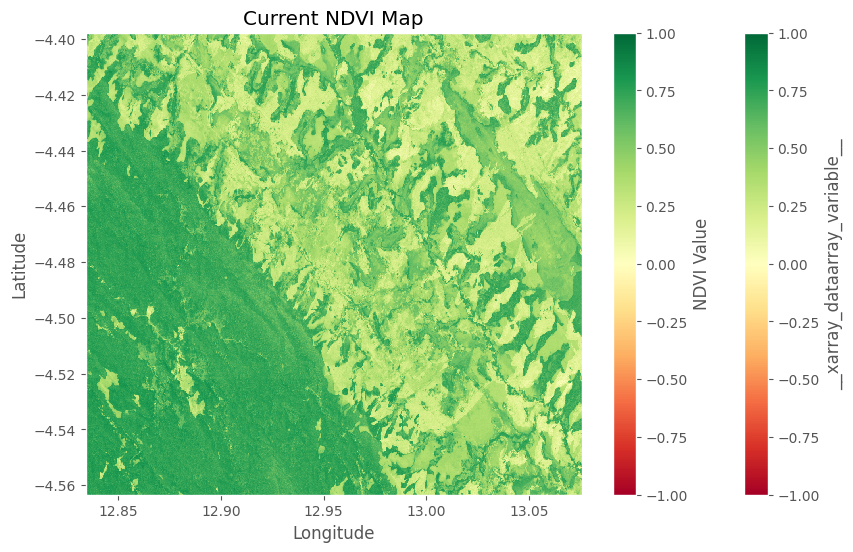

(<xarray.Dataset> Size: 9MB
 Dimensions:                        (band: 2, y: 859, x: 1250)
 Coordinates:
   * band                           (band) int32 8B 1 2
     spatial_ref                    int32 4B ...
   * x                              (x) float64 10kB 12.83 12.83 ... 13.08 13.08
   * y                              (y) float64 7kB -4.398 -4.398 ... -4.563
 Data variables:
     __xarray_dataarray_variable__  (band, y, x) float32 9MB dask.array<chunksize=(1, 859, 1250), meta=np.ndarray>,
 None)

In [37]:
# Load the current dataset
current_dataset_task = load_current_dataset(ZARR_STORE, group="kimongo-etl-job")

# Access NDVI DataArray and create a delayed task for the NDVI map
ndvi_data_task = current_dataset_task['__xarray_dataarray_variable__'][0, :, :].squeeze()

# Create a task to plot the NDVI map
ndvi_map_task = create_ndvi_map(ndvi_data_task)

# Compute the tasks
dask.compute(current_dataset_task, ndvi_map_task)

# Close the client when done
# client.close()